In [1]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

import torch
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype

from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import make_grid

from torchvision.ops import sigmoid_focal_loss

import pytorch_lightning as pl

import pl_bolts
#from pl_bolts.models.vision import UNet

from pytorch_lightning.callbacks import EarlyStopping

import torchmetrics as tm

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

Think about pre and post processing with computer vision approaches.
E.g.  
For Preprocessing: Use feature extraction like line detection as potential features into the network.  
For Postprocessing: Define clear edges and connect segments if enough is predicted to be a road.

# 1. Preparation

## 1.1 DataModule

In [3]:
class RoadSatelliteModule(pl.LightningDataModule):
    
    def __init__(self, batch_size: int = 16, num_workers: int = 8):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def prepare_data(self):
        self.train_images = self.read_images('cil_data/training/training/images/', ImageReadMode.RGB)
        self.train_masks = self.read_images('cil_data/training/training/groundtruth/', ImageReadMode.GRAY)
    
        for i, train_mask in enumerate(self.train_masks):
            self.train_masks[i][self.train_masks[i] > 0] = 1  # 255
            
        # self.train_images_float = [convert_image_dtype(img, dtype=torch.float) for img in self.train_images]
        # self.train_masks_float = [convert_image_dtype(img, dtype=torch.float) for img in self.train_masks]
            
        self.train_zip = list(zip(self.train_images, self.train_masks)) # _float
        
        test_files = [(x[0], x[2]) for x in os.walk('cil_data/test_images/test_images/')]
        self.file_names = test_files[0][1]
        self.test_images = list()
        for file_name in self.file_names:
            self.test_images.append(read_image(str('cil_data/test_images/test_images/' + file_name), ImageReadMode.RGB))
        
    def setup(self, stage=None):
        if stage in (None, 'fit'):
            train_length = int(len(self.train_zip) * 0.8)
            valid_length = len(self.train_zip) - train_length

            self.train_data, self.valid_data = random_split(self.train_zip, [train_length, valid_length])
            
        if stage in (None, 'test'):
            self.test_data = list(zip(self.test_images, self.file_names))
            
            
    def train_dataloader(self):
        return DataLoader(
            self.train_data, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=True,
            drop_last=True,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_data, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=True,
            pin_memory=True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_data, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )
    
    def read_images(self, data_dir, read_mode):
        return [read_image(data_dir + file, read_mode) for file in os.listdir(data_dir)]

In [4]:
road_data = RoadSatelliteModule()

In [5]:
road_data.prepare_data()
road_data.setup()

## 1.2 Inspect data

In [6]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
seg_images = [draw_segmentation_masks(
                image=train_pair[0], masks=train_pair[1].bool(),
                alpha=0.6,
                colors=["#00FF00"]
              ) 
              for train_pair in road_data.train_zip]

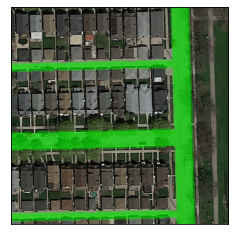

In [8]:
show_image(seg_images[69])

#for seg_image in seg_images:
#    show_image(seg_image)

In [59]:
X, y = next(iter(road_data.train_dataloader()))
print("Shapes:\nX: ", X.shape, "\ny: ", y.shape)
print("Types:\nX type: ", X.type(), "\ny type: ", y.type())
print("Datatypes:\nX dtype: ", X[0].dtype, "\ny dtype: ", y[0].dtype)

Shapes:
X:  torch.Size([16, 3, 400, 400]) 
y:  torch.Size([16, 1, 400, 400])
Types:
X type:  torch.ByteTensor 
y type:  torch.ByteTensor
Datatypes:
X dtype:  torch.uint8 
y dtype:  torch.uint8


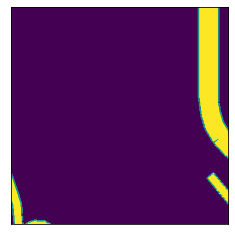

In [60]:
show_image(y[0])

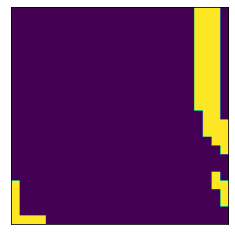

In [61]:
show_image(mask_to_patched_mask(y[0]))

In [39]:
tx, ty = next(iter(road_data.test_dataloader()))

In [40]:
print("tx: ", tx.shape)
print("ty: ", len(ty))
# print("Test Image ", ty[0], " has tensor:\n", tx[0])

tx:  torch.Size([16, 3, 608, 608])
ty:  16


# 2. System

In [11]:
class SemanticSegmentationSystem(pl.LightningModule):
    def __init__(self, model: nn.Module, datamodule: pl.LightningDataModule, lr: float = 2e-4, batch_size: int = 8):
        super().__init__()
        
        self.model = model
        self.datamodule = datamodule
        
        self.lr = lr
        self.batch_size = batch_size
        
        self.save_hyperparameters()
        

    def training_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.float()
        
        y_pred = self.model(X)
       
        loss = sigmoid_focal_loss(y_pred, y, reduction='mean')
        
        self.log('training_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.int()
        
        y_pred = self.model(X)
        y_sig = torch.sigmoid(y_pred)
       
        metric = tm.functional.accuracy(y_sig, y)
        
        self.log('validation_metric', metric)
        
        return metric
    
    def test_step(self, batch, batch_idx):
        X, name = batch
        
        X = X.float()
        
        return (self.model(X), name)
    
    def test_epoch_end(self, outputs):
        self.test_results = outputs
            
    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

    def test_dataloader(self):
        return self.datamodule.test_dataloader()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=2)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'validation_metric'
        }
    
    def visualize_results(self):
            Xs, ys = next(iter(self.val_dataloader()))
            
            y_preds = torch.sigmoid(self.model(Xs.float()))
            
            for y_pred in y_preds:
                show_image(y_pred)

    def visualize_results_overlay(self):
        Xs, ys = next(iter(self.val_dataloader()))
        
        y_preds = torch.sigmoid(self.model(Xs.float()))
        
        pred_zip = list(zip(Xs, y_preds))
        
        seg_images = [draw_segmentation_masks(train_pair[0], train_pair[1].round().bool(), alpha=0.6, colors=['#00ff00']) for train_pair in pred_zip]
        
        for seg_image in seg_images:
            show_image(seg_image)
            

# 3. Model

In [12]:
class Conv2d(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 1, 5, padding='same')
        )
        
    def forward(self, X):
        X = X.float()
        return self.model(X)

In [13]:
model = Conv2d()

In [14]:
#model = UNet(1, 3, 5, 12)  #UNet form pytorch-lightning-bolts

### Spatially dependent (nested) u-net

In [15]:
# get unet implementation: 
#     https://idiotdeveloper.com/unet-implementation-in-pytorch/
#     https://github.com/4uiiurz1/pytorch-nested-unet/blob/master/archs.py
# augment with spatial layers: 
#     https://github.com/djordjemila/sdn/blob/main/lib/nn.py
# augment with dialation: 
#     https://arxiv.org/pdf/2004.03466.pdf

In [16]:
class SDNCell(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gru = GRUCell(input_size=3*num_features, hidden_size=num_features)

    def forward(self, neighboring_features, features):
        """ Update current features based on neighboring features """
        return self.gru(torch.cat(neighboring_features, dim=1), features)


class _CorrectionLayer(nn.Module):

    def __init__(self, num_features, dir=0):
        super().__init__()
        self.num_features = num_features
        self.cell = SDNCell(num_features)
        if dir == 0:
            self.forward = self.forward0
        elif dir == 1:
            self.forward = self.forward1
        elif dir == 2:
            self.forward = self.forward2
        else:
            self.forward = self.forward3
        self.zero_pad = None

    def _get_zero_pad(self, batch, device):
        if self.zero_pad is None or self.zero_pad.shape[0] != batch:
            self.zero_pad = torch.zeros((batch, self.num_features, 1), device=device)  # no grad ??
        return self.zero_pad

    def forward0(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d - 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward1(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d + 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward2(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, d - 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward3(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, d + 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features


class SDNLayer(nn.Module):
    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        # project-in network
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.project_in_stage = cnn_module(in_ch, num_features, kernel_size, stride, padding)
        # correction network
        sdn_correction_layers = []
        for dir in dirs:
            sdn_correction_layers.append(_CorrectionLayer(num_features, dir=dir))
        self.sdn_correction_stage = nn.Sequential(*sdn_correction_layers)
        # project-out network
        self.project_out_stage = nn.Conv2d(num_features, out_ch, 1)

    def forward(self, x):
        # (I) project-in stage
        x = self.project_in_stage(x)
        x = torch.tanh(x)
        # (II) correction stage
        x = x.contiguous(memory_format=torch.channels_last)
        x = self.sdn_correction_stage(x)
        x = x.contiguous(memory_format=torch.contiguous_format)
        # (III) project-out stage
        x = self.project_out_stage(x)
        return x


class ResSDNLayer(nn.Module):

    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        self.sdn = SDNLayer(in_ch, 2 * out_ch, num_features, dirs, kernel_size, stride, padding, upsample)
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.cnn = cnn_module(in_ch, out_ch, kernel_size, stride, padding)

    def forward(self, input):
        cnn_out = self.cnn(input)
        sdn_out, gate = self.sdn(input).chunk(2, 1)
        gate = torch.sigmoid(gate)
        return gate * cnn_out + (1-gate) * sdn_out

In [17]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [18]:
class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        #nb_filter = [32, 64, 128, 256, 512]
        nb_filter = [32, 64, 256]
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block(input_channels, nb_filter[0])
        self.conv1_0 = conv_block(nb_filter[0], nb_filter[1])
        self.conv2_0 = conv_block(nb_filter[1], nb_filter[2])
        #self.conv3_0 = conv_block(nb_filter[2], nb_filter[3])
        #self.conv4_0 = conv_block(nb_filter[3], nb_filter[4])

        #self.conv3_1 = conv_block(nb_filter[3]+nb_filter[4], nb_filter[3])
        #self.conv2_2 = conv_block(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv1_3 = conv_block(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv0_4 = conv_block(nb_filter[0]+nb_filter[1], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        #x3_0 = self.conv3_0(self.pool(x2_0))
        #x4_0 = self.conv4_0(self.pool(x3_0))

        
        
        #x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        #x2_2 = self.conv2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_0)], 1))  #x2_2
        x0_4 = self.conv0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [19]:
class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()
        
        # depth = 4
        # use loop instead of defining all the convs individually

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block(input_channels, nb_filter[0])
        self.conv1_0 = conv_block(nb_filter[0], nb_filter[1])
        self.conv2_0 = conv_block(nb_filter[1], nb_filter[2])
        self.conv3_0 = conv_block(nb_filter[2], nb_filter[3])
        self.conv4_0 = conv_block(nb_filter[3], nb_filter[4])

        self.conv0_1 = conv_block(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = conv_block(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = conv_block(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = conv_block(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = conv_block(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = conv_block(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = conv_block(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = conv_block(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = conv_block(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = conv_block(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

In [20]:
model = UNet(1, 3)

In [21]:
system = SemanticSegmentationSystem(model, road_data)

# 4. Inspect System and Model

In [23]:
summary(model, input_size=(system.batch_size, 3, 400, 400))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─conv_block: 1-1                        [8, 32, 400, 400]         --
│    └─Conv2d: 2-1                       [8, 32, 400, 400]         896
│    └─BatchNorm2d: 2-2                  [8, 32, 400, 400]         64
│    └─ReLU: 2-3                         [8, 32, 400, 400]         --
│    └─Conv2d: 2-4                       [8, 32, 400, 400]         9,248
│    └─BatchNorm2d: 2-5                  [8, 32, 400, 400]         64
│    └─ReLU: 2-6                         [8, 32, 400, 400]         --
├─MaxPool2d: 1-2                         [8, 32, 200, 200]         --
├─conv_block: 1-3                        [8, 64, 200, 200]         --
│    └─Conv2d: 2-7                       [8, 64, 200, 200]         18,496
│    └─BatchNorm2d: 2-8                  [8, 64, 200, 200]         128
│    └─ReLU: 2-9                         [8, 64, 200, 200]         --
│    └

## 4.1 Shapes and Types

In [ ]:
y_pred = model(X.float())
y_pred.shape

In [ ]:
system.training_step((X, y), 0)

In [ ]:
system.validation_step((X, y), 0)

## 4.2 Visual

In [ ]:
#system.visualize_results_overlay()

In [ ]:
#system.visualize_results()

# 5. Training

In [ ]:
early_stop_callback = EarlyStopping(
   monitor='validation_metric',
   patience=5,
   verbose=2,
   mode='max'
)

In [ ]:
if torch.cuda.is_available():
    gpu_count = -1
    print("GPUs detected.")
    print("There should be ", torch.cuda.device_count(), " GPUs available.")
else:
    gpu_count = 0
    print("No GPU detected.")
    print("Working with CPU")

gpu_count

In [ ]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    #max_epochs = 1,  # at least 1 requried. Only for testing the prediction
    gpus=gpu_count,
    auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    stochastic_weight_avg=True,
    logger=False,
    deterministic=True,
    callbacks=[early_stop_callback]
)

In [ ]:
system.hparams

In [ ]:
# trainer.tune(system)

In [ ]:
trainer.fit(system)

# 6.Predict Data

In [ ]:
predictions = trainer.test()

In [ ]:
batches = system.test_results

In [ ]:
len(batches)

In [ ]:
batches[0][0].shape

In [52]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

def mask_to_submission_strings(im, name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", name).group(0))
    #im = mpimg.imread(image_filename) 
    # image is gray scale therefore size MxN with imread 
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for imgs, fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs, fn))

In [25]:
submission_filename = "some_predictions.csv"

In [26]:
pred_counter = 0

with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        # iterate over batches and get the ids and predictions
        for masks, names in batches:
            for i, mask in enumerate(masks):
                #print("mask ", i, " is: ", names[i])
                predicted_mask = np.asarray(torch.sigmoid(mask).squeeze())

                ids = mask_to_submission_strings(predicted_mask, names[i])
                # print('\n'.join(id))
                f.writelines('{}\n'.format('\n'.join(ids)))

                pred_counter += 1
pred_counter

NameError: name 'batches' is not defined

# 7. Inspect Results

In [ ]:
system.visualize_results_overlay()

In [ ]:
system.visualize_results()

# 8. Scratch Area to try out things at the bottom

In [ ]:
class SDUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Spatial Depenent Layers
        
        # Convolutional Layer
        # also try dialated for longer reach 
        
        
        self.model = nn.Sequential(
            
        )
        
    def forward(self, X):
        X = X.float()
        return self.model(X)